# Ouroboros: Experiments

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import logging
import warnings

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn import linear_model as LR
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
BASE_PATH = os.path.dirname(os.path.abspath('__file__'))

SELF_LEARNER_MODULE_PATH = os.path.abspath(os.path.join(BASE_PATH, os.path.pardir))
SELF_LEARNER_LIB_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'selflearner')
os.chdir(SELF_LEARNER_LIB_PATH)
sys.path.insert(0, SELF_LEARNER_MODULE_PATH)

# Paths of dump
import pickle
CLASSES_CNT_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'classes_count.pkl')
EXP_OUROBOROS_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_ouroboros.pkl')
EXP_PREVIOUS_PRES_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_previous_pres.pkl')
EXP_OUROBOROS_SAMPLING_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_ouroboros_sampling.pkl')

from selflearner.multi_day_experiment import MultiDayExperiment
from selflearner.problem_definition import ProblemDefinition, TrainingType
from selflearner.data_load.features_extraction_oulad import Hdf5Creator
import selflearner.selflearner_utils
from selflearner.learning.dead_students_classifier import NeverActiveStudentClassifier
from selflearner.plotting.plotting import plot_df

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def lazy_load(file_name, slow_comp_function, args=[], kwargs=None, force_recompute=False):
    """
    Takes care of taking the already pickled experiment so that is not necessary to recompute it.
    """
    if force_recompute is True:
        logging.info("Force recomputation of the models.")
        return slow_comp_function(*args, **kwargs)
    try:
        with open(file_name, "rb") as f:
            logging.debug('Loading from pickle...')
            obj = pickle.load(f)
    except IOError:
        obj = slow_comp_function(*args, **kwargs)
        with open(file_name, "wb") as f:
                pickle.dump(obj, f)
    return obj
    
def compute_experiment(train_mode=TrainingType.SELFLEARNER, max_days=0, module_presentations=None, assessment_name=None,classifiers=None, features=None, sampler=None):
    # Init and run the experiment
    dailyExpPrevPres = MultiDayExperiment(max_days, 
                                        module_presentations=module_presentations,
                                        assessment_name=assessment,
                                        classifiers=classifiers,
                                        features=features,
                                        training_type=train_mode,
                                        sampler=sampler)
    dailyExpPrevPres.perform_experiment()
    return dailyExpPrevPres

Setting variables for the experiment.

In [3]:
modules = ["BBB", "DDD", "EEE", "FFF"]
presentations = ["2014J"]
assessment = "TMA 1"
features = ["demog"]
label_name = "submitted"
sampler = None
max_days = 11

Load all the module and presentations, filtered by the specified variables 

In [4]:
manager = Hdf5Creator().get_hdf5_manager()
df_modules = manager.load_dataframe('courses').reset_index()
df_modules = df_modules.loc[
    df_modules['code_module'].isin(modules) & df_modules['code_presentation'].isin(presentations)]
module_presentations = []
for index, row in df_modules.iterrows():
    module, presentation = row['code_module'], row['code_presentation']
    presentation_train = presentation
    module_presentations.append((module, presentation, presentation_train))
    
module_presentations_previous = []
for index, row in df_modules.iterrows():
    module, presentation = row['code_module'], row['code_presentation']
    presentation_train = selflearner.selflearner_utils.get_prev_pres_same(presentation)
    module_presentations_previous.append((module, presentation, presentation_train))

## Class numbers

Extracting number of classes for training and testing data across all days.

In [5]:
def load_or_compute_classes():
    try:
        with open(CLASSES_CNT_DUMP_PATH, "rb") as f:
            expClassNumbers = pickle.load(f)
    except IOError:
        classifiers = [(DummyClassifier(strategy="constant", constant=1), "Base[NS]")
                       ]
        # Init and run the experiment
        expClassNumbers = MultiDayExperiment(max_days, 
                                                module_presentations=module_presentations, 
                                                assessment_name=assessment,
                                                classifiers=classifiers)
        expClassNumbers.perform_experiment()
        with open(CLASSES_CNT_DUMP_PATH, "wb") as f:
                pickle.dump(expClassNumbers, f)
    return expClassNumbers

%time expClassNumbers = load_or_compute_classes()

CPU times: user 123 ms, sys: 57.8 ms, total: 180 ms
Wall time: 197 ms


Daily distribution of class labels normalised into [0;1]. It can be seen that closer to the cutoff date the data are more balanced both for training and testing data. The plot depicts relative counts for label=1, number of NotSubmit.

The further from cutoff, the more NotSubmit data are in training data and less in testing data. More students submit over the time, so more of Submit occur in the training data and there are less students remaining to submit (hence lowering the number of Submit in testing data).

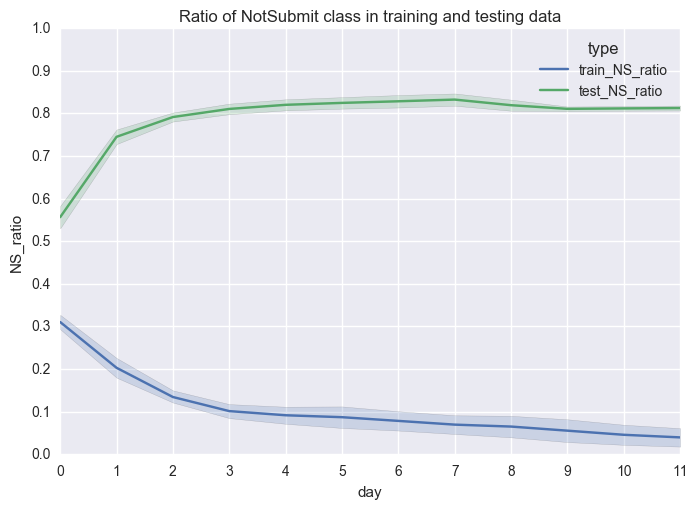

In [6]:
expClassNumbers.plot_class_counts()

## Daily Experiments

### Init classifiers for all experiments 

In [7]:
classifiers = [(SVC(kernel="rbf", gamma='auto', C=1, probability=True, class_weight="balanced"), "SVM-W-R"),
       (SVC(kernel="rbf", gamma='auto', C=1, probability=True), "SVM-R"),
       (LR.LogisticRegression(C=0.01, penalty='l2'), "LR"),
       (LR.LogisticRegression(C=0.01, penalty='l2', class_weight="balanced"), "LR-W"),
       (GaussianNB(), "NB"),
       (RandomForestClassifier(n_estimators=120, max_depth=5, min_samples_split=2, min_samples_leaf=5), "RF"),
       (xgb.XGBClassifier(base_score=0.1, n_estimators=100, max_depth=3, reg_alpha=0.5, reg_lambda=1, learning_rate=0.01 ), "XGB"),
#                (NeverActiveStudentClassifier(), "Base[NotAccessed]"),
#                (DummyClassifier(strategy="constant", constant=1), "Base[NS]")
              ]

features = [
      'demog'
    , 'vle_statistics'
    , 'vle_statistics_beforestart'
    , 'vle_day_activity_type_flags'
    , 'vle_day_activity_type'
    , 'vle_day'
    , 'vle_day_flags'
    , 'reg_statistics'
  ]

### Training using the same course - Ouroboros

This is first part of the experiments, the selected classifiers were run for the selected modules in the 2014J presentation trained using the same presentation. The experiments were conducted for the cutoff and 11 days before.

In [8]:
kwargs = {'train_mode': TrainingType.SELFLEARNER,
          'max_days': max_days,
          'module_presentations':module_presentations_previous,
          'assessment_name':assessment,
          'classifiers':classifiers, 'features':features}
%time dailyExpSelflearner = lazy_load(EXP_OUROBOROS_DUMP_PATH, compute_experiment, kwargs=kwargs)

CPU times: user 575 ms, sys: 1.98 s, total: 2.56 s
Wall time: 3.08 s


In [9]:
dailyExpSelflearner.get_metric_daily_df('pr_auc')

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
day,,,,,,,
0,0.756305,0.768005,0.672665,0.771933,0.743469,0.778691,0.744239
1,0.527015,0.594221,0.473318,0.612627,0.408271,0.616130,0.596489
2,0.386633,0.492562,0.391593,0.535967,0.313224,0.542596,0.531409
3,0.302634,0.415323,0.364028,0.511730,0.262323,0.471359,0.522449
4,0.286678,0.394743,0.375996,0.483433,0.255108,0.458165,0.507884
5,0.257152,0.386341,0.361039,0.467096,0.235785,0.427278,0.491941
6,0.219378,0.360205,0.367932,0.443209,0.218866,0.416517,0.519942
7,0.206393,0.324429,0.361562,0.420459,0.202430,0.400551,0.495944
8,0.227083,0.334251,0.365124,0.453468,0.195507,0.410167,0.530922


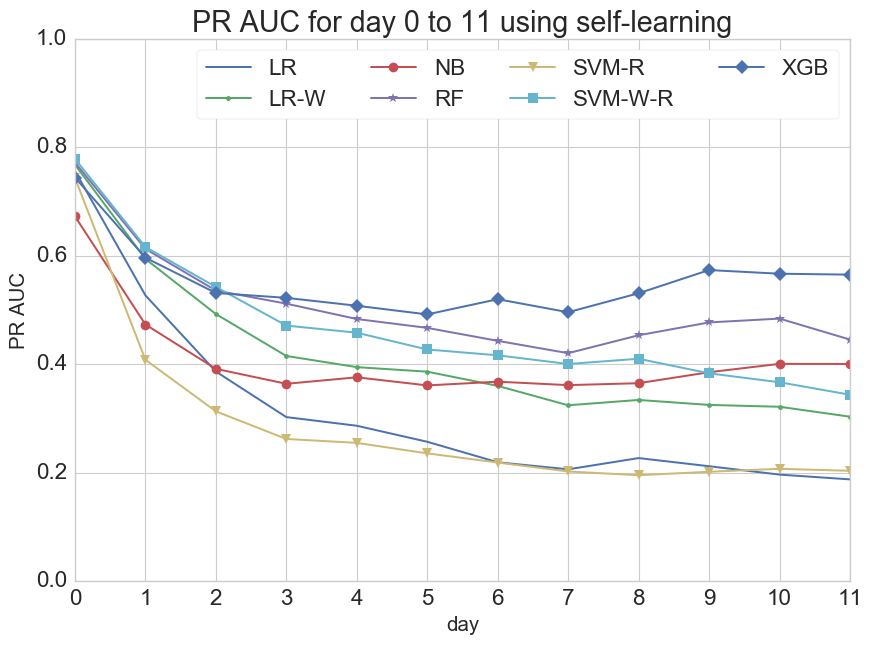

In [10]:
dailyExpSelflearner.plot_metric('pr_auc', metric_friendly_name='PR AUC',label_postfix='using self-learning', width=10, height=7)

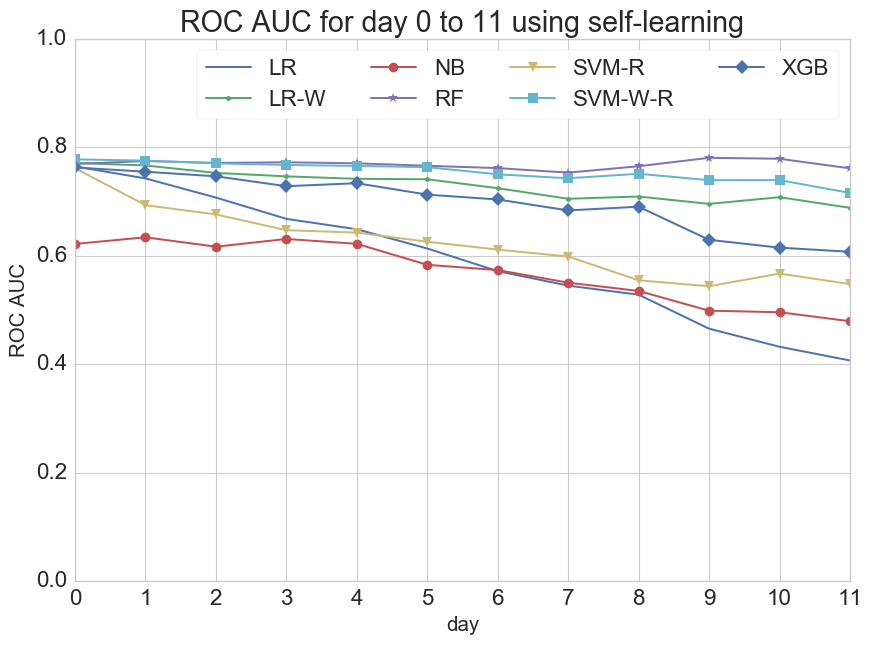

In [11]:
dailyExpSelflearner.plot_metric('auc', metric_friendly_name='ROC AUC',label_postfix='using self-learning', width=10, height=7)

###  Training using previous presentation


Same experiment as the previous one but the training is performed using the data from the previous presentation, i.e. 2013J.

In [12]:
kwargs = {'train_mode': TrainingType.PREVIOUS_PRES, 'max_days': max_days,
                  'module_presentations':module_presentations_previous,'assessment_name':assessment,
                  'classifiers':classifiers, 'features':features}
%time dailyExpPrevPres = lazy_load(EXP_PREVIOUS_PRES_DUMP_PATH, compute_experiment, kwargs=kwargs)

CPU times: user 791 ms, sys: 2.47 s, total: 3.26 s
Wall time: 4.1 s


In [13]:
dailyExpPrevPres.get_metric_daily_df('pr_auc')

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
day,,,,,,,
0,0.555364,0.591382,0.540807,0.638560,0.558781,0.633455,0.614821
1,0.534639,0.570195,0.539954,0.594881,0.539753,0.605562,0.586223
2,0.506449,0.538207,0.537804,0.572098,0.506383,0.563419,0.561358
3,0.490158,0.518850,0.535913,0.543398,0.483046,0.538192,0.519200
4,0.478410,0.509414,0.536392,0.528283,0.469752,0.526277,0.513981
5,0.469502,0.499128,0.538250,0.494484,0.461040,0.514594,0.500409
6,0.462265,0.489833,0.534114,0.502977,0.453059,0.502030,0.495332
7,0.456740,0.483885,0.531131,0.492878,0.448703,0.494688,0.500474
8,0.503408,0.529871,0.559374,0.547373,0.492470,0.540212,0.543315


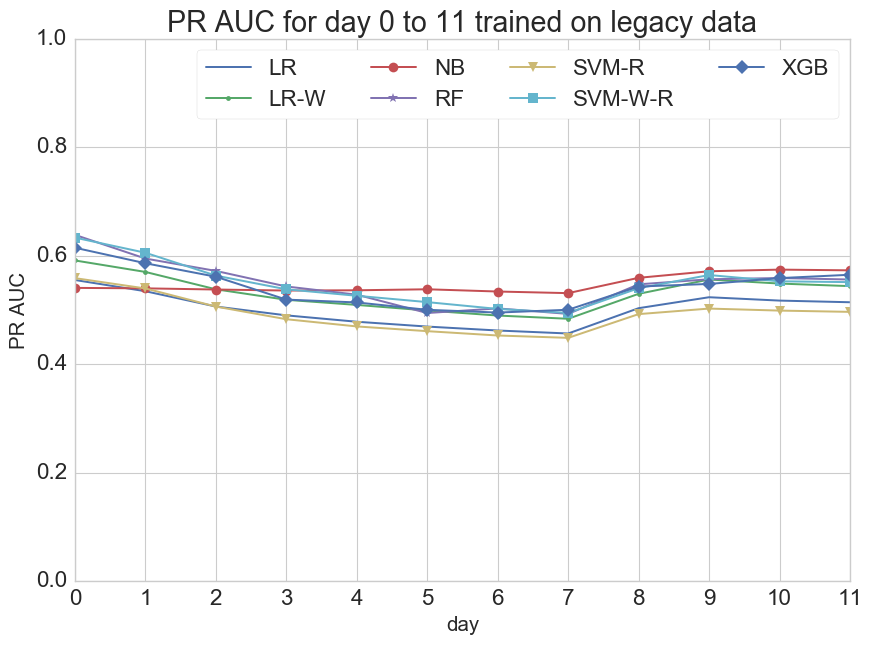

In [14]:
dailyExpPrevPres.plot_metric('pr_auc', metric_friendly_name='PR AUC', label_postfix='trained on legacy data', width=10, height=7)

### Top-K-Precision and Top-K-recall -- Ouroboros

Experiment with Top-K-Precision and Recall for $k \in \{ 5,10,15,25,50 \}.$

#### Top K Precision 

In [15]:
top_k_graph_width = 7
top_k_graph_height = 5

In [16]:
dailyExpSelflearner.get_metric_daily_df('top_k_prec', 5)

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
day,,,,,,,
0,0.942008,0.930103,0.552919,0.956612,0.889109,0.952462,0.917190
1,0.692078,0.781071,0.333222,0.837456,0.403410,0.841154,0.780269
2,0.526555,0.684408,0.218741,0.771240,0.304562,0.775870,0.547857
3,0.366524,0.573660,0.219199,0.711174,0.217641,0.674791,0.430737
4,0.340159,0.512604,0.192217,0.699953,0.196965,0.629834,0.443253
5,0.288921,0.507522,0.189376,0.634845,0.147487,0.601148,0.394317
6,0.234736,0.445603,0.166237,0.609857,0.154495,0.564558,0.330646
7,0.225429,0.395765,0.148632,0.565541,0.122949,0.535834,0.319334
8,0.222833,0.365156,0.156597,0.633407,0.142462,0.521847,0.344971


In [17]:
dailyExpSelflearner.get_metric_daily_df('top_k_prec', 10)

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
day,,,,,,,
0,0.914758,0.941178,0.552919,0.924087,0.906926,0.953083,0.892837
1,0.657397,0.749698,0.333222,0.775127,0.433853,0.781886,0.714533
2,0.495905,0.620763,0.218741,0.662854,0.317140,0.667999,0.523649
3,0.352014,0.543328,0.219199,0.629364,0.260849,0.602521,0.430737
4,0.325616,0.485806,0.192217,0.597070,0.244451,0.567952,0.443253
5,0.270535,0.479327,0.189376,0.563148,0.211329,0.532418,0.394317
6,0.236229,0.432637,0.166237,0.551173,0.184128,0.508150,0.330646
7,0.233358,0.391290,0.148632,0.514680,0.154046,0.503567,0.319334
8,0.240722,0.398718,0.156597,0.555899,0.143549,0.530783,0.344971


In [18]:
dailyExpSelflearner.get_metric_daily_df('top_k_prec', 25)

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
day,,,,,,,
0,0.803210,0.814634,0.552919,0.828166,0.821788,0.826300,0.811046
1,0.522896,0.563801,0.363807,0.573847,0.441009,0.579853,0.548447
2,0.382673,0.459069,0.250908,0.470956,0.352901,0.472259,0.449654
3,0.315488,0.405074,0.248317,0.440766,0.285423,0.433632,0.368878
4,0.291382,0.380772,0.204158,0.409018,0.278539,0.407482,0.362037
5,0.239311,0.365786,0.196722,0.403763,0.248557,0.402224,0.273658
6,0.211224,0.353158,0.175273,0.392722,0.222761,0.377391,0.304651
7,0.194741,0.321478,0.148632,0.369091,0.200751,0.361778,0.291114
8,0.222438,0.355538,0.156822,0.410763,0.174132,0.403382,0.320906


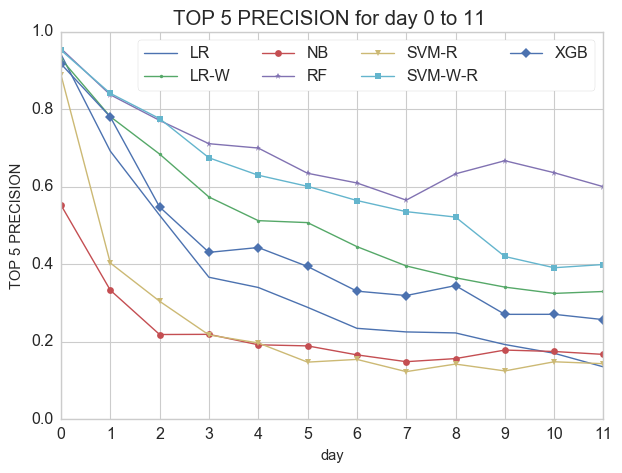

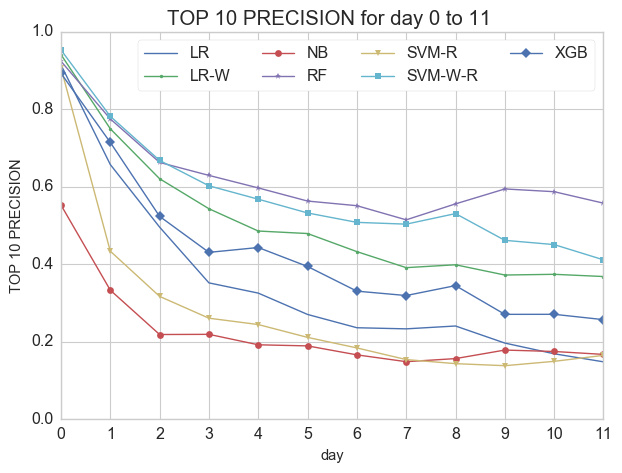

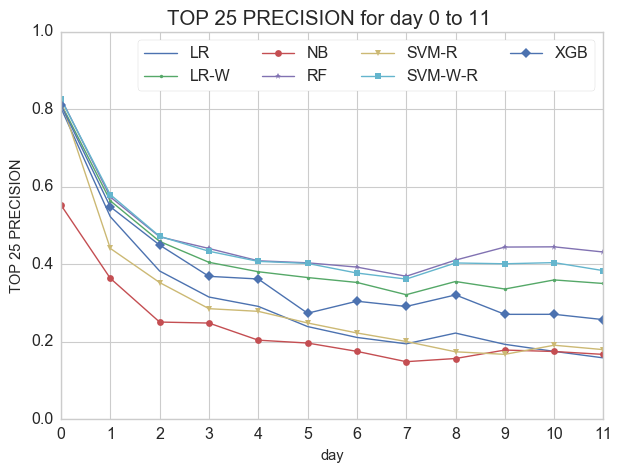

In [19]:
dailyExpSelflearner.plot_metric('top_k_prec', k=5, metric_friendly_name='TOP 5 PRECISION', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_prec', k=10, metric_friendly_name='TOP 10 PRECISION', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_prec', k=25, metric_friendly_name='TOP 25 PRECISION', width=top_k_graph_width, height=top_k_graph_height)

#### Top K Recall 

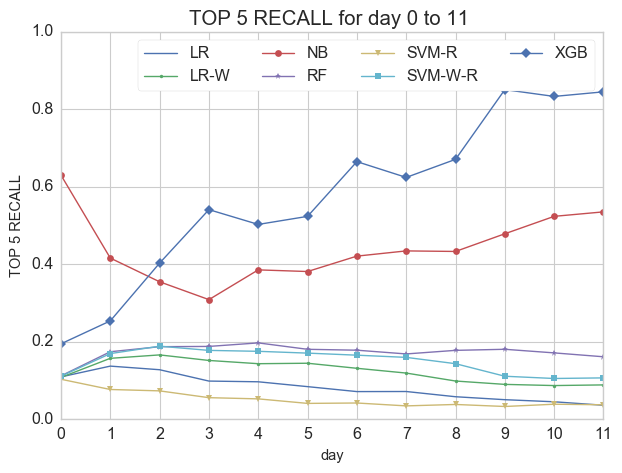

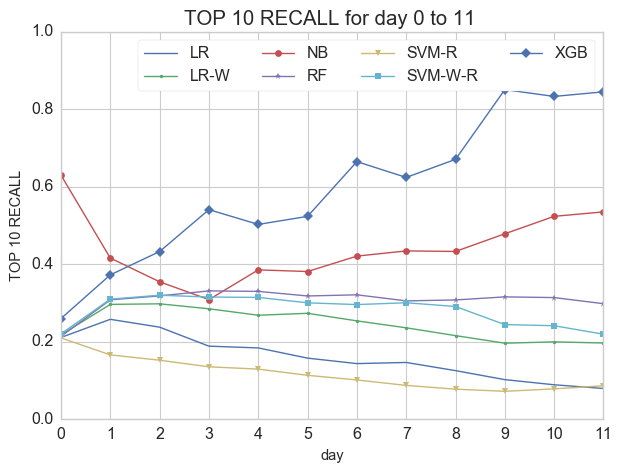

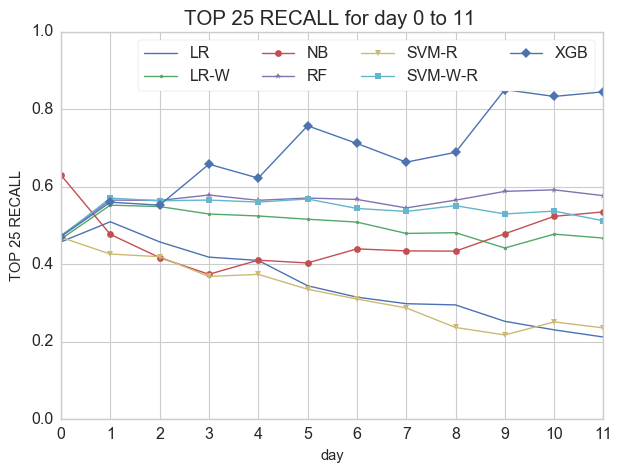

In [20]:
dailyExpSelflearner.plot_metric('top_k_rec', k=5, metric_friendly_name='TOP 5 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_rec', k=10, metric_friendly_name='TOP 10 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_rec', k=25, metric_friendly_name='TOP 25 RECALL', width=top_k_graph_width, height=top_k_graph_height)

### Top-K-Precision and Top-K-recall -- Previous presentation

The same experiment but training using the previous presentation.

#### Top K Precision 

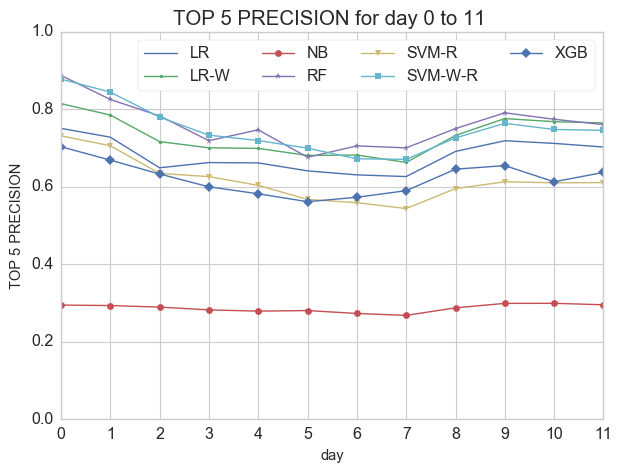

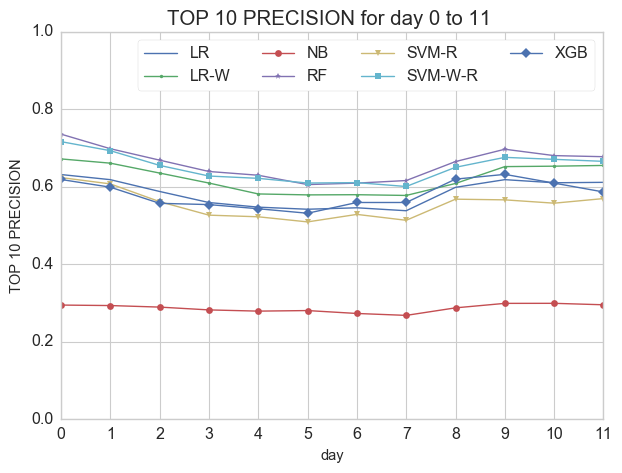

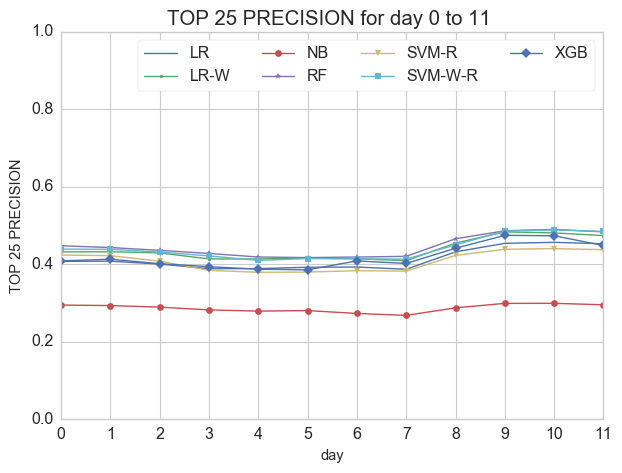

In [21]:
dailyExpPrevPres.plot_metric('top_k_prec', k=5, metric_friendly_name='TOP 5 PRECISION',  width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_prec', k=10, metric_friendly_name='TOP 10 PRECISION', width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_prec', k=25, metric_friendly_name='TOP 25 PRECISION',  width=top_k_graph_width, height=top_k_graph_height)

#### Top K Recall 

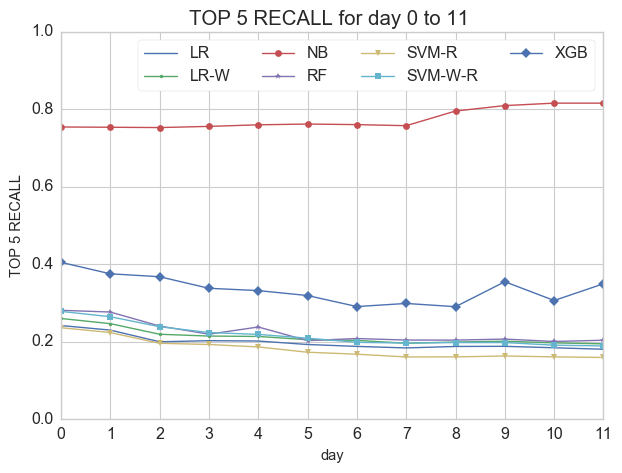

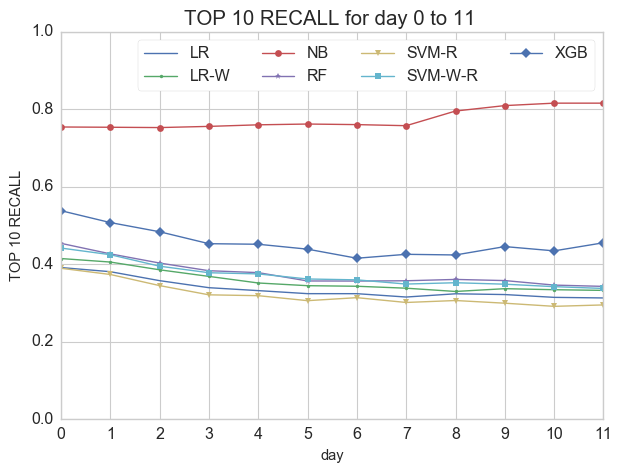

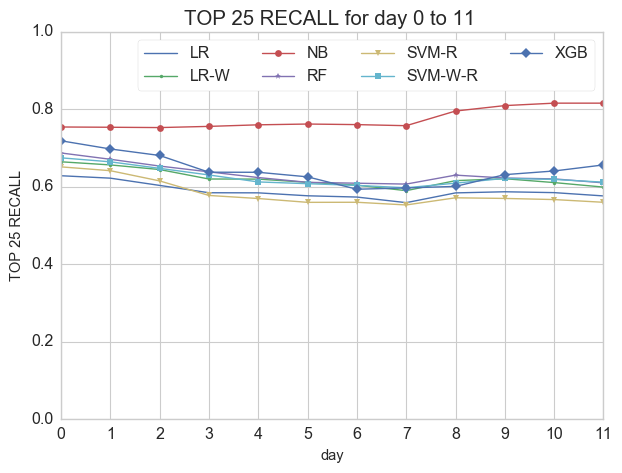

In [22]:
dailyExpPrevPres.plot_metric('top_k_rec', k=5, metric_friendly_name='TOP 5 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_rec', k=10, metric_friendly_name='TOP 10 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_rec', k=25, metric_friendly_name='TOP 25 RECALL', width=top_k_graph_width, height=top_k_graph_height)

## Daily experiments with sampling 

This experiment is the same as the daily experiment using learning on the same presentation. Moreover, here the sampling methods are used to modify the distribution of the training data to deal with the imbalanced distribution.

In [23]:
from imblearn.under_sampling import TomekLinks 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

In [24]:
# If the sampling algorithm is changed and you want to re-run the experiment, it's important to force the rerun
# for the lazy loader
sampler = TomekLinks() 

kwargs = {'train_mode': TrainingType.SELFLEARNER,
          'max_days': max_days,
          'module_presentations': module_presentations,
          'assessment_name':assessment,
          'classifiers':classifiers, 
          'features':features,
          'sampler':sampler}
%time dailyExpSampling = lazy_load(EXP_OUROBOROS_SAMPLING_DUMP_PATH, compute_experiment, kwargs=kwargs)

CPU times: user 633 ms, sys: 1.99 s, total: 2.62 s
Wall time: 3.28 s


### Results 

In [25]:
dailyExpSampling.get_metric_daily_df('pr_auc')

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
day,,,,,,,
0,0.756678,0.768398,0.674560,0.771892,0.746552,0.778745,0.746960
1,0.528461,0.594684,0.478516,0.617030,0.414972,0.616919,0.596188
2,0.387157,0.492641,0.394128,0.546375,0.314014,0.542397,0.531679
3,0.303041,0.415036,0.364526,0.507980,0.262510,0.470673,0.524084
4,0.287405,0.394678,0.378012,0.491418,0.254774,0.459388,0.508648
5,0.257410,0.386558,0.356941,0.465777,0.237215,0.426738,0.490571
6,0.219492,0.360194,0.367766,0.452858,0.216026,0.416227,0.520450
7,0.206349,0.323990,0.362200,0.441300,0.201173,0.399804,0.497493
8,0.226270,0.333570,0.365287,0.450176,0.195718,0.409021,0.533532


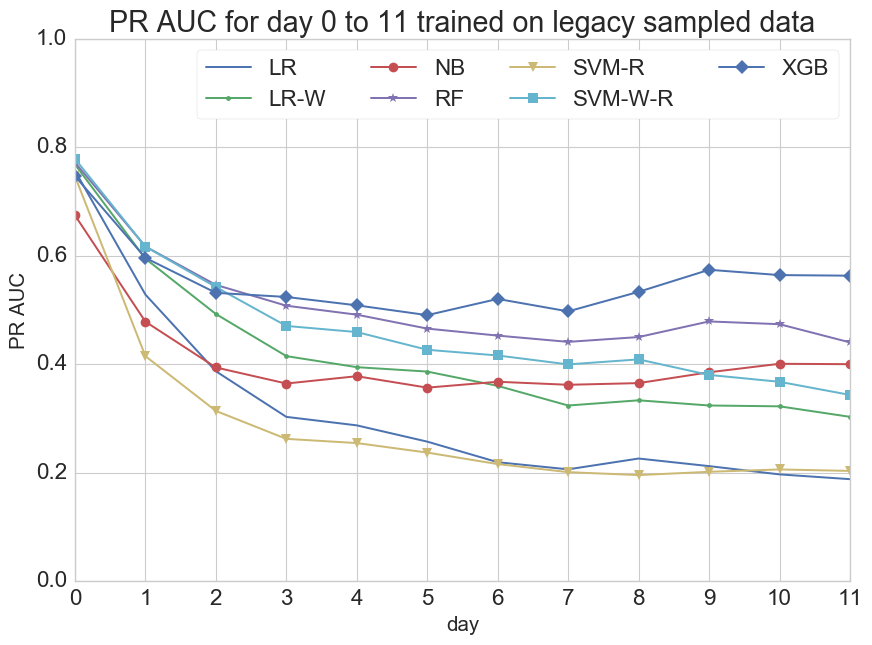

In [26]:
dailyExpSampling.plot_metric('pr_auc', metric_friendly_name='PR AUC', label_postfix='trained on legacy sampled data', width=10, height=7)

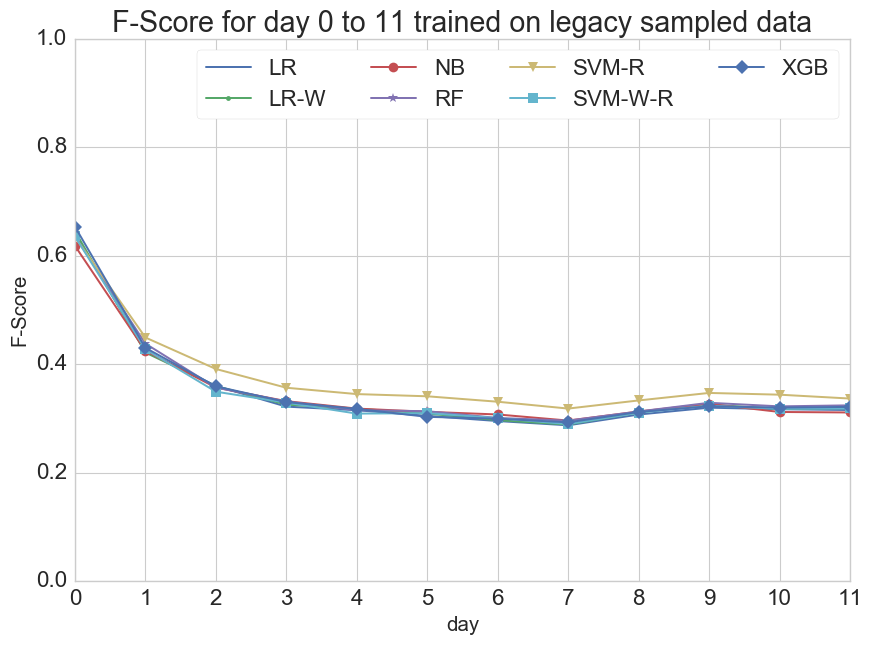

In [27]:
dailyExpSampling.plot_metric('fscore', metric_friendly_name='F-Score', label_postfix='trained on legacy sampled data', width=10, height=7)

## Feature importance

Top N features for the selected algorithms and in the selected days, for the paper days 0,3 and 7 were presented.

In [28]:
num_of_top_features = 5
classifier  = 'XGB'
selected_days = [0,3,7]

df = dailyExpSelflearner.get_features_df()
df = df[df.day.isin(selected_days)]

In [29]:
g  = df[['code_module','day','feature_name',classifier]].set_index(['code_module','day'])
g = g.groupby(level=[0,1], group_keys=False)
g = g.apply(lambda x: x.sort_values(classifier, ascending=False))
g["rank"] = g.groupby(level=[0,1])[classifier].rank(method="first",ascending=False).apply(lambda x:int(x))
g = g[['feature_name','rank']]
g.groupby(level=[0,1]).head(num_of_top_features).reset_index().set_index(['code_module','rank','day']).unstack()

feature_name                                                                  
day                                                         0                               3                                 7
code_module rank                                                                                                               
BBB         1                                     first_login          count_days_fromvleopen            count_days_fromvleopen
            2               median_clicks_fromstart_peractive            is_click_7.0_subpage             sum_click_fromvleopen
            3     median_material_count_beforestart_peractive          is_click_6.0_oucontent           sum_click_9.0_oucontent
            4                        sum_material_fromvleopen           sum_click_2.0_forumng             sum_click_9.0_subpage
            5                                      last_login        sum_material_fromvleopen          sum_click_13.0_oucontent
DDD         1                          sum_material_fromstart        sum_material_fromvleopen          sum_click_30.0_oucontent
            2                                      last_login         sum_click_1.0_oucontent            sum_click_5.0_glossary
            3                                 studied_credits           sum_click_fromvleopen             sum_click_fromvleopen
            4                           sum_click_6.0_forumng        sum_click_38.0_oucontent            sum_click_4.0_glossary
            5                         sum_click_9.0_oucontent          sum_click_7.0_glossary            sum_click_2.0_glossary
EEE         1                                      last_login  avg_clicks_fromstart_peractive                    sum_click_36.0
            2                  avg_clicks_fromstart_peractive        sum_click_34.0_oucontent               sum_click_20.0_quiz
            3                                   sum_click_3.0             sum_click_11.0_quiz                    sum_click_31.0
            4                          count_days_beforestart             sum_click_18.0_quiz                 sum_click_6.0_url
            5                        sum_material_fromvleopen          sum_click_12.0_subpage  avg_clicks_beforestart_peractive
FFF         1                                      last_login        sum_material_fromvleopen            count_days_fromvleopen
            2                          sum_material_fromstart  avg_clicks_fromstart_peractive        sum_click_8.0_htmlactivity
            3                        sum_material_fromvleopen          sum_click_33.0_subpage            is_click_1.0_oucontent
            4                          count_days_fromvleopen                   sum_click_4.0              is_click_22.0_ouwiki
            5                           sum_click_6.0_forumng         sum_click_10.0_resource              is_click_9.0_forumng